**Table of contents**<a id='toc0_'></a>    
- [(Optional) LLM Master Examples with Ollama](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [**1. Data Preparation**](#toc1_2_)    
    - [**1.1 Load data**](#toc1_2_1_)    
    - [**1.2 Save data**](#toc1_2_2_)    
  - [**2. Using Ollama with Local Open Source LLMs**](#toc1_3_)    
    - [**2.1 Text Prompting**](#toc1_3_1_)    
    - [**2.2 Structured Output**](#toc1_3_2_)    
    - [**2.3 Multi-Modal Prompting - Text + Images**](#toc1_3_3_)    
    - [**2.4 Tool Calling:**](#toc1_3_4_)    
      - [General Idea](#toc1_3_4_1_)    
    - [**2.5 Information Extraction and Grounding:**](#toc1_3_5_)    
      - [`langextract`: A Library for Grounded Extraction**](#toc1_3_5_1_)    
        - [**Using PDF Documents:**](#toc1_3_5_1_1_)    
    - [**2.6 Retrieval-Augmented Generation (RAG)**](#toc1_3_6_)    
        - [**Actual content in the URL:**](#toc1_3_6_1_1_)    
    - [**2.7 Generating LLM Embeddings:**](#toc1_3_7_)    
    - [**2.8 Few-Shot Prompting Classification:**](#toc1_3_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[(Optional) LLM Master Examples with Ollama](#toc0_)


**Remember that this notebook is not worth any points, it's just extra material**.

---
## <a id='toc1_1_'></a>[Introduction](#toc0_)

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embeddings and other deep information retrieval approaches.

![pic0.png](./pics/pic0.png)

---
## <a id='toc1_2_'></a>[**1. Data Preparation**](#toc0_)

### <a id='toc1_2_1_'></a>[**1.1 Load data**](#toc0_)

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [64]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [65]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [66]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [67]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [68]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### <a id='toc1_2_2_'></a>[**1.2 Save data**](#toc0_)

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [69]:
## save to pickle file
train_df.to_pickle("./data/train_df.pkl") 
test_df.to_pickle("./data/test_df.pkl")

In [70]:
import pandas as pd

## load a pickle file
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---

## <a id='toc1_3_'></a>[**2. Using Ollama with Local Open Source LLMs**](#toc0_)

`Before starting you need to have ollama running in the background of your environment.` If you are on your laptop you just need to open the app once and then it will be running the server that python uses in the background. 

It should show something like this in order to be used by python: 

![ollama_background](./pics/ollama_background.png)

If you are in Kaggle or in Colab, after downloading ollama and pulling the required models with the commands explained in the `README.md` it should be ready to be used by python.

*Note that some exercises from the LLM section of our main Master Notebook are not able to be replicated with Ollama*, like being able to do image segmentation, or passing down videos, audio or youtube urls, those can only be replicated by big multi-modal models like Gemini, and in the case of youtube urls that is only possible because it is a Google model with their API service.

If you would like to you can also watch this short tutorial in how to use ollama: 

[Learn Ollama in 15 Minutes - Run LLM Models Locally for FREE](https://www.youtube.com/watch?v=UtSSMs6ObqY)

---

### <a id='toc1_3_1_'></a>[**2.1 Text Prompting**](#toc0_)
Like with ChatGPT we can use these models to ask about anything. Here we are going to ask a question and then ask it to return it in markdown format to make it look better afterwards.

In [70]:
import ollama
response = ollama.chat(model='gemma3:270m', messages=[
    {
        'role': 'user',
        'content': 'What is data mining? Elaborate on related topics. (in markdown format)'
    },
])

print(response['message']['content'])

## Data Mining: A Deep Dive

Data mining is a subfield of computer science that focuses on extracting meaningful insights and patterns from large amounts of data. It involves using data to solve complex problems, make better decisions, and gain a deeper understanding of the world.

**Core Concepts:**

*   **Data Collection:** Gathering data from various sources, including databases, spreadsheets, sensors, and other physical objects.
*   **Data Cleaning and Preprocessing:** Handling missing values, correcting inconsistencies, and transforming data to ensure its quality and consistency.
*   **Data Analysis:**  Identifying patterns, trends, anomalies, and relationships within the data.  This involves techniques like:
    *   **Association Rule Mining:** Discovering relationships between variables.
    *   **Descriptive Statistics:** Calculating descriptive statistics (mean, median, standard deviation) to understand data distribution.
    *   **Machine Learning:**  Developing algorithms th

**We can use the IPython library to make the response look better:**

In [ ]:
from IPython.display import display, Markdown
display(Markdown('*some markdown* $\phi$'))

*some markdown* $\phi$

In [72]:
display(Markdown(response['message']['content']))

## Data Mining: A Deep Dive

Data mining is a subfield of computer science that focuses on extracting meaningful insights and patterns from large amounts of data. It involves using data to solve complex problems, make better decisions, and gain a deeper understanding of the world.

**Core Concepts:**

*   **Data Collection:** Gathering data from various sources, including databases, spreadsheets, sensors, and other physical objects.
*   **Data Cleaning and Preprocessing:** Handling missing values, correcting inconsistencies, and transforming data to ensure its quality and consistency.
*   **Data Analysis:**  Identifying patterns, trends, anomalies, and relationships within the data.  This involves techniques like:
    *   **Association Rule Mining:** Discovering relationships between variables.
    *   **Descriptive Statistics:** Calculating descriptive statistics (mean, median, standard deviation) to understand data distribution.
    *   **Machine Learning:**  Developing algorithms that learn from data to predict or classify outcomes.
*   **Data Visualization:**  Presenting data in a clear, concise, and understandable way using charts, graphs, and other visual aids.
*   **Feature Engineering:** Creating new features from existing data to improve the accuracy and usefulness of the learned insights.
*   **Model Building:** Developing predictive models that can answer specific questions or make predictions.
*   **Interpretation and Understanding:**  Communicating the insights and findings from the data mining process to stakeholders.

**Key Areas of Data Mining:**

*   **Business Intelligence (BI):**  Analyzing data to support decision-making and improve business performance.  Examples include:
    *   **Marketing:**  Analyzing customer behavior to personalize marketing campaigns.
    *   **Sales:**  Identifying trends in sales data to improve forecasting and sales strategies.
    *   **Finance:**  Analyzing financial data to detect fraud and optimize investment decisions.
*   **Healthcare:**  Analyzing patient data to identify disease patterns, predict treatment outcomes, and improve healthcare delivery.  Examples include:
    *   **Medical Imaging:** Analyzing medical images to detect anomalies and diagnose diseases.
    *   **Drug Discovery:**  Predicting the effectiveness of drug candidates based on their chemical structure.
*   **Natural Language Processing (NLP):**  Analyzing text data to extract meaning, understand language, and identify sentiment. Examples include:
    *   **Customer Support:**  Analyzing customer feedback to improve customer service.
    *   **Sentiment Analysis:**  Determining the emotional tone of text data.
    *   **Machine Translation:**  Analyzing text data to improve machine translation accuracy.
*   **Internet of Things (IoT):**  Analyzing data from connected devices to gain insights into their behavior and optimize their operation. Examples include:
    *   **Smart Home Automation:**  Monitoring and controlling devices in homes.
    *   **Industrial IoT:**  Analyzing data from sensors and other devices to optimize industrial processes.
    *   **Environmental Monitoring:**  Analyzing data from sensors to monitor environmental conditions.
*   **Fraud Detection:**  Identifying patterns and anomalies in financial transactions that may indicate fraud.  Examples include:
    *   **Credit Card Fraud Detection:**  Analyzing transaction data to detect fraudulent activities.
    *   **Insurance Fraud Detection:**  Identifying patterns in insurance claims to prevent fraud.
*   **Personalized Recommendations:**  Recommending products, services, or content to individual users based on their preferences and past behavior.  Examples include:
    *   **Recommendation Engines:**  Suggesting products or services based on user data.
    *   **Personalized Marketing:**  Tailoring marketing messages to individual customer segments.
    *   **Personalized Content Recommendations:**  Suggesting content based on user interests and preferences.

**Common Data Mining Techniques:**

*   **Association Rule Mining:**  Discovering relationships between variables.
*   **Descriptive Statistics:**  Calculating descriptive statistics to understand data distribution.
*   **Machine Learning:**  Developing algorithms that learn from data to make predictions or classifications.
*   **Feature Engineering:**  Creating new features from existing data to improve the accuracy and usefulness of the learned insights.
*   **Clustering:**  Grouping similar data points together.
*   **Anomaly Detection:**  Identifying unusual patterns or outliers in data.

**Challenges in Data Mining:**

*   **Data Quality:**  Data must be accurate, complete, and consistent.
*   **Data Availability:**  Access to large datasets can be limited.
*   **Data Integration:**  Integrating data from multiple sources can be complex.
*   **Interpretability:**  Understanding the insights derived from the data can be challenging.
*   **Bias:**  Data can contain biases that can be reflected in the insights.
*   **Scalability:**  Data mining systems need to be scalable to handle large volumes of data.
*   **Security:**  Protecting sensitive data from unauthorized access and breaches.

**In Summary:**

Data mining is a powerful and versatile field that leverages data to solve complex problems and gain valuable insights. By understanding the principles and techniques involved, data scientists can improve decision-making, optimize processes, and create new products and services. While data mining can be challenging, it is a rapidly evolving field with a wide range of applications.


---
### <a id='toc1_3_2_'></a>[**2.2 Structured Output**](#toc0_)

By default, an LLM responds with unstructured, free-form text. For data mining, this is often impractical, as we need data in a predictable format to load into tools like a pandas DataFrame for analysis. **Structured output** is a powerful feature that forces the model to return its response in a specific, machine-readable format, such as JSON.

The key to enabling this is to provide the model with a **response schema**. This schema acts as a strict template or blueprint that the model's output must conform to. Instead of generating a paragraph, the model will fill in the fields defined in your schema with the relevant information it extracts from the prompt.

In the following code, we define this schema using Python classes. Think of each class as defining a JSON object:
*   The **attributes** of the class (e.g., `topic_name`, `sub_title`) become the keys in the final JSON object.
*   The **type hints** for those attributes (e.g., `str`, `list`) tell the model what kind of data is expected for each key's value.

We can even nest these classes inside one another to create complex, hierarchical JSON structures. This allows us to precisely control the format of the output, transforming the LLM from a simple text generator into a reliable tool for automated and structured data extraction.

[Ollama's Structured Output Documentation](https://ollama.com/blog/structured-outputs)

For data validation of schemas Gemini API uses the Pydantic library, for more documentation on it you can check: [Pydantic](https://docs.pydantic.dev/latest/) 

[JSON Format Documentation](https://docs.python.org/3/library/json.html)

In [1]:
import ollama
from pydantic import BaseModel

# We define our structure schema that our ollama model should follow for the output response

# Subsections on the topics we query
class Subsection(BaseModel):
    sub_title: str
    sub_explanation: str

# The middle structure to define what a topic object should have
class Topic(BaseModel):
    topic_name: str
    subsections: list[Subsection]

# The top-level structure that groups all of our Topic Objects
class TopicsList(BaseModel):
    topics: list[Topic]

input_prompt = 'Explain what are machine learning, data centers, llms and how do they relate to each other. **Answer in the provided JSON schema**'
system_prompt = 'You are a helpful assistant that answers any question in the provided **JSON Schema**'
# Note: gemma3:270m is a small model so it might not be good to understand structured output, you can try with bigger models
# We input our json schema in the "format" parameter
response = ollama.chat(model='gemma3:270m', 
                       format=TopicsList.model_json_schema(), # Set our schema
                       options={'temperature': 0},  # Set temperature to 0 for more deterministic output
                       messages=[
                        {
                            'role': 'system',
                            'content': system_prompt # Instruction prompt for the model
                        },
                        {
                            'role': 'user',
                            'content': input_prompt # Our prompt
                        },
                    ]
)

# We validate that the output follows our schema
topics = TopicsList.model_validate_json(response.message.content)
print(topics)

topics=[Topic(topic_name='Machine Learning', subsections=[Subsection(sub_title='What is Machine Learning?', sub_explanation="Machine learning is a subset of machine learning. It involves training algorithms on data to learn patterns and make predictions or decisions without explicit programming. It's a powerful technique for automating tasks, improving accuracy, and uncovering hidden insights in data."), Subsection(sub_title='Data Centers', sub_explanation='Data centers are physical locations where data is stored, processed, and stored. They are essential for hosting and running large-scale machine learning models. They provide the infrastructure and resources needed to support the training and deployment of these models.'), Subsection(sub_title='LLMs (Large Language Models)', sub_explanation='LLMs are a type of machine learning model that is trained on massive amounts of text data. They are capable of understanding and generating human-like text, which is used for a wide range of appl

In [2]:
# We can obtain the json dict in this way:
struct_topics = topics.model_dump()
struct_topics

{'topics': [{'topic_name': 'Machine Learning',
   'subsections': [{'sub_title': 'What is Machine Learning?',
     'sub_explanation': "Machine learning is a subset of machine learning. It involves training algorithms on data to learn patterns and make predictions or decisions without explicit programming. It's a powerful technique for automating tasks, improving accuracy, and uncovering hidden insights in data."},
    {'sub_title': 'Data Centers',
     'sub_explanation': 'Data centers are physical locations where data is stored, processed, and stored. They are essential for hosting and running large-scale machine learning models. They provide the infrastructure and resources needed to support the training and deployment of these models.'},
    {'sub_title': 'LLMs (Large Language Models)',
     'sub_explanation': 'LLMs are a type of machine learning model that is trained on massive amounts of text data. They are capable of understanding and generating human-like text, which is used for a

In [3]:
print(type(struct_topics))

<class 'dict'>


In [ ]:
# Explore all the topics names
for topic in struct_topics['topics']:
    print(topic['topic_name'])

Machine Learning
Data Centers


In [ ]:
# Explore the subsections of the topics
for topic in struct_topics['topics']:
    for subsection in topic['subsections']:
        print(subsection['sub_title'])

What is Machine Learning?
Data Centers
LLMs (Large Language Models)
Data Centers
Machine Learning Models
Machine Learning Algorithms


In [ ]:
# We can structure all together
for topic in struct_topics["topics"]:
    print(f'\n\nTopic: {topic["topic_name"]}')
    for subsection in topic["subsections"]:
        print(f'\nSubsection: {subsection["sub_title"]}')
        print(f'\tExplanation: {subsection["sub_explanation"]}\n')



Topic: Machine Learning

Subsection: What is Machine Learning?
	Explanation: Machine learning is a subset of machine learning. It involves training algorithms on data to learn patterns and make predictions or decisions without explicit programming. It's a powerful technique for automating tasks, improving accuracy, and uncovering hidden insights in data.


Subsection: Data Centers
	Explanation: Data centers are physical locations where data is stored, processed, and stored. They are essential for hosting and running large-scale machine learning models. They provide the infrastructure and resources needed to support the training and deployment of these models.


Subsection: LLMs (Large Language Models)
	Explanation: LLMs are a type of machine learning model that is trained on massive amounts of text data. They are capable of understanding and generating human-like text, which is used for a wide range of applications, including chatbots, text-to-speech, and content generation.



Topic

---

### <a id='toc1_3_3_'></a>[**2.3 Multi-Modal Prompting - Text + Images**](#toc0_)
Multi-modal prompting involves using input from multiple sources or modes, such as text, images, or audio, to guide a model's response. It allows AI to process and generate information based on more than one type of input.

For image plus text prompting, the model receives both an image and a related text prompt. The image provides visual context, while the text gives additional guidance. The model uses both inputs to generate more accurate and contextually relevant responses, which is useful for tasks like image captioning, visual question answering, or content generation based on visual cues.

Let's look at the following images that are in the **pics** folder in the directory of this notebook:

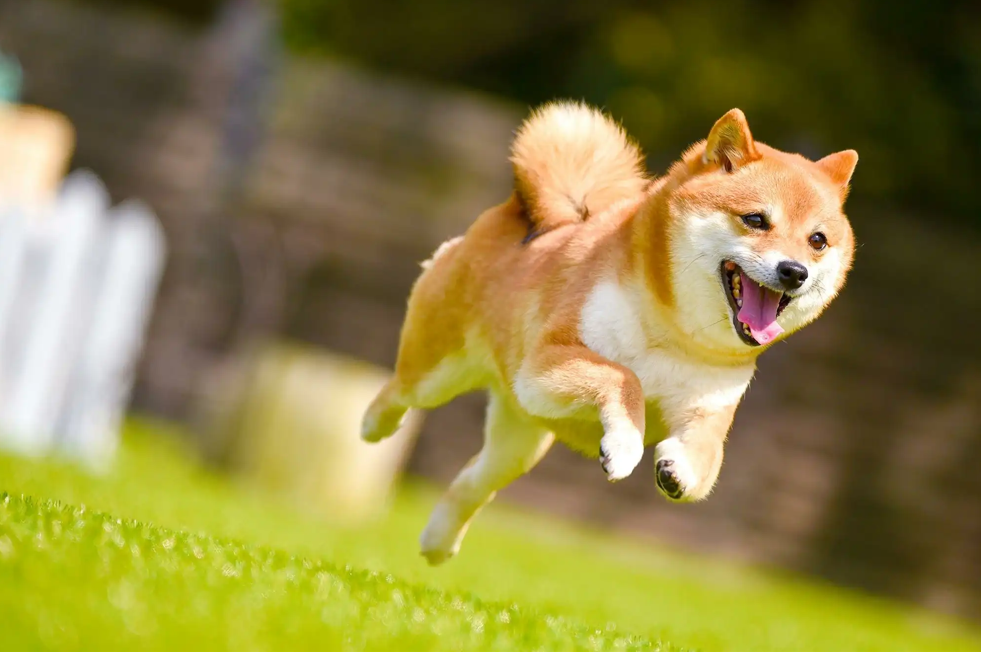

source: https://cooljapan-videos.com/tw/articles/epe0y86g

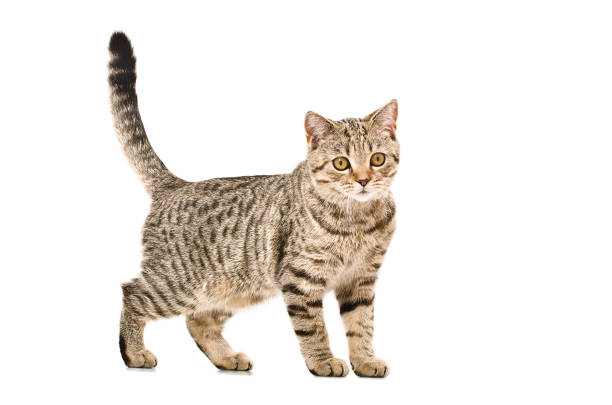

source: https://www.istockphoto.com/photo/young-cat-scottish-straight-gm1098182434-294927481

We will use the **llava-phi3** model that we installed to request a description of the images:

In [165]:
import ollama
response2 = ollama.chat(model='gemma3:4b', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': ['./pics/example1.png'] #Image with the dog
    },
])

display(Markdown(response2['message']['content']))

This image is about a Shiba Inu dog mid-air, captured in a dynamic and joyful moment. 

Here's a breakdown:

*   **Subject:** It's a Shiba Inu, a breed known for its fox-like appearance and playful personality.
*   **Action:** The dog is leaping, frozen in motion.
*   **Mood:** The image conveys energy, excitement, and happiness. 

Shiba Inus have become incredibly popular online, especially for their expressive faces and lively antics, making this image a relatable and charming depiction of a beloved breed.

In [166]:
response3 = ollama.chat(model='gemma3:4b', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': ['./pics/example2.jpg'] #Image with the cat
    },
])

display(Markdown(response3['message']['content']))

The image is a close-up photograph of a beautiful tabby cat. Specifically, it appears to be a British Shorthair due to its dense, plush coat and round face. The cat is standing with its tail raised, giving it a regal and alert expression. 

It's a classic, appealing image of a well-groomed feline.

---

### <a id='toc1_3_4_'></a>[**2.4 Tool Calling:**](#toc0_)

Up to now we have seen how prompting, text and multimodal, lets a model **generate responses directly.** But sometimes we want the model to do more than just talk: to **fetch information, compute something, or take an action.** This is where tool calling (also called *function calling* or *agents*) comes in.

#### <a id='toc1_3_4_1_'></a>[General Idea](#toc0_)

Tool calling means the model can decide, instead of replying only with text, to **call an external function** that you have made available. You give the model a list of tools, each described by their **name, purpose, and input parameters,** and the model chooses when to use them.

So the order is something like this:
1.	You declare tools (name, purpose, inputs).
2.	The model checks the user request and may return a function_call.
3.	Your system runs the function.
4.	The result is sent back, and the model uses it to craft the final response.

For more information you can check: [Ollama Documentation | Tool Support](https://ollama.com/blog/tool-support)

List of ollama models that support `tools`: [Supported models](https://ollama.com/search?c=tools)

For this example we are going to use `llama3.2:1b` because it supports tool calling with ollama.

In [27]:
def simple_math(a: int, b: int, operation: str) -> int | float:
    """
    Performs a simple mathematical operation on two numbers.
    Args:
        a: The first number.
        b: The second number.
        operation: The operation to perform. Must be one of 'add', 'subtract', 'multiply', or 'divide'.
    Returns:
        The result of the mathematical operation.
    """
    # Double validating the input
    a = int(a)
    b = int(b)
    if operation == 'add':
        return a + b
    elif operation == 'subtract':
        return a - b
    elif operation == 'multiply':
        return a * b
    elif operation == 'divide':
        return a / b
    else:
        raise ValueError("Invalid operation. Please choose from 'add', 'subtract', 'multiply', or 'divide'.")

In [32]:
simple_math_declaration = {
      'type': 'function',
      'function': {
        'name': 'simple_math',
        'description': 'Perform a simple mathematical operation',
        'parameters': {
          'type': 'object',
          'properties': {
            'a': {
              'type': 'integer',
              'description': 'The first number',
            },
            'b': {
              'type': 'integer',
              'description': 'The second number',
            },
            'operation': {
                'type': 'string',
                'enum': ["add", "subtract", "multiply", "divide"],
                'description': "The mathematical operation to perform, one of 'add', 'subtract', 'multiply', 'divide'",
            }
          },
          'required': ['a', 'b', 'operation'],
        },
      },
    }

In [54]:
import ollama
# Example tool calling with ollama
# You can try changing this prompt to use substraction, multiplication or division
user_input = 'What is 5 plus 10?'
response = ollama.chat(
    model='llama3.2:1b',
    messages=[{'role': 'user', 'content': user_input}],
    tools=[simple_math_declaration],
)

print(response['message']['tool_calls'])

[ToolCall(function=Function(name='simple_math', arguments={'a': '5', 'b': '10', 'operation': 'add'}))]


In [55]:
response.message.tool_calls[0].function.arguments

{'a': '5', 'b': '10', 'operation': 'add'}

In [ ]:
# IMPORTANT: For more functions you can add new ones in this dictionary 
available_functions = {
  'simple_math': simple_math,
}

In [57]:
function_output = None
if response.message.tool_calls:
  # There may be multiple tool calls in the response
  for tool in response.message.tool_calls:
    # Ensure the function is available, and then call it
    if function_to_call := available_functions.get(tool.function.name):
      print('Calling function:', tool.function.name)
      print('Arguments:', tool.function.arguments)
      function_output = function_to_call(**tool.function.arguments)
      print('Function output:', function_output)
    else:
      print('Function', tool.function.name, 'not found')

Calling function: simple_math
Arguments: {'a': '5', 'b': '10', 'operation': 'add'}
Function output: 15


In [60]:
from IPython.display import display, Markdown


system_prompt_agent = "You are a tool agent that needs to answer back to the user in a polite manner in Markdown format.\
                        Answer back in an objective manner referencing only the result of the tool call."
concluding_remark = f"The user asked: {user_input} \nThe result of the tool call was this: {function_output} \
                        \nGive a response to the user:"
response_agent = ollama.chat(
    model='llama3.2:1b',
    messages=[{'role': 'system', 'content': system_prompt_agent},
              {'role': 'user', 'content': concluding_remark}],
)
display(Markdown(response_agent["message"]["content"]))

# Calculated Result
The result of the calculation `5 + 10` is:

```
15
```

# Explanation
This result is based on the provided input and the calculations performed by the tool. The tool successfully added 5 and 10 together, resulting in a total of 15.

---
### <a id='toc1_3_5_'></a>[**2.5 Information Extraction and Grounding:**](#toc0_)

We've already seen how to get structured data from LLMs using techniques like structured prompting and function calling. These methods are powerful for turning an LLM's understanding into a machine-readable format. However, as we build more complex applications, two critical challenges emerge: **trust** and **scalability**.

1.  **Trust and Verifiability (Grounding):** How can we be sure the information an LLM provides is accurate and actually comes from the source text we gave it? LLMs can sometimes "hallucinate" or infer information that isn't present. **Grounding** is the process of linking every piece of extracted data directly back to its specific origin in the source document. This creates a verifiable audit trail, allowing a human or another system to confirm the information's source, which is essential in high-stakes domains like medicine, finance, and legal analysis.

2.  **Scalability and Reliability (Extraction):** While function calling is excellent for specific tasks, building a robust pipeline to extract complex information from long, messy documents requires a more specialized approach. We need a system that can handle large texts, consistently enforce a desired output schema across thousands of documents, and make the results easy for humans to review.

This is where specialized libraries for information extraction come in, providing a framework that prioritizes both grounding and reliable structuring of data.

---
#### <a id='toc1_3_5_1_'></a>[`langextract`: A Library for Grounded Extraction**](#toc0_)

Google's open-source Python library, `langextract`, is designed specifically to solve these problems. It uses the power of LLMs to convert unstructured text into structured data, with a strong emphasis on reliability and traceability. Instead of just getting a JSON object, `langextract` provides a complete solution for building trustworthy extraction pipelines.

Here are its key features:

*   **Precise Source Grounding:** This is the library's core strength. Every single piece of extracted data is mapped to its exact character position in the original text. This means you can always trace an output back to its source, building trust and allowing for easy verification.
*   **Reliable Structured Outputs:** We define the structure of our desired output by providing a few examples (few-shot prompting). `langextract` uses these examples to guide the LLM, ensuring the output consistently follows our defined schema. This makes the data clean, predictable, and ready for analysis or storage.
*   **Adaptable to Any Domain without Fine-Tuning:** We don't need to collect a large dataset or retrain a model. By simply changing our natural language instructions and examples, you can adapt `langextract` to new domains, whether it's extracting clinical data from medical notes, key clauses from legal contracts, or financial figures from earnings reports.
*   **Optimized for Long Documents:** The library is built to handle lengthy texts that might exceed a standard LLM's context window. It employs smart chunking and multi-pass strategies to effectively find "needles in a haystack" within large documents.
*   **Flexible LLM Support:** `langextract` is model-agnostic. While it's optimized for powerful models like Google's Gemini or OpenAI models, it also supports local, open-source models (via Ollama), or even custom providers, giving us the flexibility to balance performance, cost, and data privacy.

**`Github repository:`** [langextract](https://github.com/google/langextract)

---

##### <a id='toc1_3_5_1_1_'></a>[**Using PDF Documents:**](#toc0_)

For PDF Document information extraction we are going to use the `pymupdf` library. Documentation: [pymupdf](https://pymupdf.readthedocs.io/en/latest/)

And then we are going to pass it on to langextract to get insights on the document's content.

In [93]:
import pymupdf
# Extract text from the PDF and format it for the prompt
# This is a review from the movie interstellar
pdf_path = "./data/documents/doc_example_review_interstellar.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './data/documents/doc_example_review_interstellar.pdf'


In [94]:
print(formatted_text)

**Page 1**
"""
Dan Baldwin
Group 4
Auteur Review - Interstellar 
I believe Christopher Nolan: the director behind the 2014 sci-ﬁ/adventure cinematic ‘Interstellar,’ 
to be a very intellectual and imaginative inventive talent.  
His style in his previous ﬁlms sets characters in epic unique locations, with gargantuan issues to 
face, and artistically impresses the audience with how the characters solve their problems. For 
example, in Nolan’s 2010 ﬁlm ‘Inception,’ he tackles the idea of dreams, and sets his characters 
diving through dreams within dreams within even more dreams to complete their goals. Because 
this idea is so farfetched, and dreams are a subject in which science has made little factual 
discovery in, Nolan is free to use his creativity to present ideas such as landscapes folding in on 
themselves and corridors spinning, without seeming unrealistic. 
This brain-racking epic theme is once again evident in ‘Interstellar,’ as Nolan sets his characters 
during a second Ameri

In [143]:
import langextract as lx
import textwrap

# Defining the extraction prompt for "movie review" type of data
prompt = textwrap.dedent("""\
    You are an information extraction agent that grounds the text data with the input.
    Extract specific opinions and their impact on the audience from this movie review.
    Important: Use exact text verbatim from the input to put in the extracted text. Do not paraphrase.
    Extract entities in order of appearance with no overlapping text spans.
                         
    Format your answer in the provided JSON Format like in the examples:
    """)

# Providing high-quality examples to guide the model
# These examples show the model exactly how to differentiate between the two classes
examples = [
    # Example: Demonstrates a positive opinion on the plot and its direct impact on the reviewer
    lx.data.ExampleData(
        text="The film boasts a truly clever plot that kept me guessing until the very end.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="a truly clever plot",
                attributes={
                    "subject": "The plot",
                    "sentiment": "Positive",
                    "key_phrase": "truly clever"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="kept me guessing until the very end",
                attributes={
                    "emotion_evoked": ["engaged", "curious"],
                    "causal_element": "The plot",
                    "target_audience": "the reviewer"
                }
            ),
        ]
    )
]

Here we define our main function to call for langextract information extraction, note that there are some constants in the functions that we are not going to change for the example but it would be required to explore and understand in the exercise. In this function we obtain the resulting raw extracted information into a .jsonl file and the visualization into a .html file. Check the documentation for more information.

The files will be saved in the following directory: `results/info_extractions`

In [167]:
import os
import langextract as lx
from langextract.core import data

# We define our main langextract function 
def grounded_info_extraction(input_documents, prompt, examples, file_name, model_id ="gemma3:4b", extraction_passes = 1, max_workers = 5, max_char_buffer = 400):
    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        model_url="http://localhost:11434",     # Port where ollama is located in the system/container
        extraction_passes=extraction_passes,    # Improves recall through multiple passes over the same text, needs temperature above 0.0
        max_workers=max_workers,                # Parallel processing for speed, remember there are API call rate limits, so do not abuse
        max_char_buffer=max_char_buffer,        # Smaller contexts for better accuracy, currently: 1000 characters per batch
    )

    # Display results
    print(f"Extracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")
    
    output_dir = "./results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)
    # Save results to JSONL
    lx.io.save_annotated_documents([result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    # Generate interactive visualization
    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")
    with open(f"{output_dir}/{file_name}_vis.html", "w") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"✓ Visualization saved to {output_dir}/{file_name}_vis.html")
    
    # returning html content for display
    return html_content

In [168]:
html_content = grounded_info_extraction(formatted_text, prompt, examples, file_name = "review_extraction_ollama_example")

Extracted 19 entities:

• opinion_statement: 'to be a very intellectual and imaginative inventive talent'
  - subject: Christopher Nolan
  - sentiment: Positive
  - key_phrase: very intellectual and imaginative inventive
• opinion_statement: 'artistically impresses the audience'
  - subject: the audience
  - sentiment: Positive
  - key_phrase: artistically impresses
• opinion_statement: 'is so farfetched'
  - subject: The idea
  - sentiment: Negative
  - key_phrase: so farfetched
• audience_impact: 'without seeming unrealistic'
  - emotion_evoked: ['comfortable', 'trusting']
  - causal_element: Nolan is free to use his creativity
  - target_audience: the audience
• opinion_statement: 'a truly clever plot'
  - subject: The plot
  - sentiment: Positive
  - key_phrase: truly clever
• audience_impact: 'kept me guessing until the very end'
  - emotion_evoked: ['engaged', 'curious']
  - causal_element: The plot
  - target_audience: the reviewer
• opinion_statement: 'a truly clever plot'
  - 

LangExtract: Saving to results\info_extractions\review_extraction_ollama_example.jsonl: 1 docs [00:00, 102.42 docs/s]

✓ Saved 1 documents to results\info_extractions\review_extraction_ollama_example.jsonl



LangExtract: Loading results\info_extractions\review_extraction_ollama_example.jsonl: 100%|█████████▉| 10.6k/10.6k [00:00<00:00, 2.70MB/s]

✓ Loaded 1 documents from results\info_extractions\review_extraction_ollama_example.jsonl
✓ Visualization saved to ./results/info_extractions/review_extraction_ollama_example_vis.html


In [169]:
html_content

---
### <a id='toc1_3_6_'></a>[**2.6 Retrieval-Augmented Generation (RAG)**](#toc0_)
RAG (Retrieval-Augmented Generation) is a technique where a language model combines document retrieval with text generation. In RAG, a retrieval system first finds relevant documents or text chunks, and then the language model uses this retrieved information to generate a more informed and accurate response. This method enhances the model's ability to answer questions by grounding its responses in real, external data.

In the following code, we will load a webpage as a document, which allows us to retrieve text from a URL. After loading the content, we will split the document into smaller, manageable chunks, making it easier for our model to process. Then, we'll generate embeddings for these chunks with a specified LLM model (e.g., embeddinggemma). These embeddings will be stored in a vector database, which enables us to perform similarity searches. By setting up this retrieval system, we can use a RAG chain to answer questions. The retriever finds relevant text chunks from the document based on a query, and the LLM (e.g. gemma3:270m) generates a response by incorporating this retrieved information, making the answers more grounded and accurate.

In [30]:
import ollama
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

llm_model = "embeddinggemma" #You can change to the one of your preference

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict() 
    ) 
    docs = loader.load() #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    #print(splits) #You can print this to see how the chunks in the url where split
    embeddings = OllamaEmbeddings(model=llm_model) #Generating embeddings with our chosen model
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()

url="https://www.ibm.com/think/topics/large-language-models"
# Create the retriever
retriever = load_and_retrieve_docs(url)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Ollama LLM function
def ollama_llm(question, context):
    # print("Context:",context, "\n")
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='gemma3:270m', messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context)

# Use the RAG chain
result = rag_chain("Based on the context, what is explained about the new architectures that have emerged?")
display(Markdown(result))

Based on the provided context, the new architectures that have emerged are:

*   **Mamba models:** These are state-space models with selective updates that efficiently filter and combine past information, allowing them to capture long-range dependencies.
*   **Diffusion LLMs:** These models start with random noise and gradually denoise it step by step, guided by a learned model, until coherent text emerges.



##### <a id='toc1_3_6_1_1_'></a>[**Actual content in the URL:**](#toc0_)

We see that the output does retrieve the correct new architectures described in the blog from IBM.

![ibm.png](./pics/ibm_llms.png)

source: https://www.ibm.com/think/topics/large-language-models


---

### <a id='toc1_3_7_'></a>[**2.7 Generating LLM Embeddings:**](#toc0_)
LLM embeddings are dense vector representations of text generated by Large Language Models. These embeddings, like we have already seen in the lab, capture the semantic meaning and relationships between words, phrases, or even entire documents by mapping them into a high-dimensional space where similar pieces of text are placed closer together. What makes LLM embeddings special is that they are contextual and rich in meaning, meaning the same word can have different embeddings based on its surrounding context.

For example, the word **"bank"** would have different embeddings in the sentences **"I sat by the river bank"** and **"I deposited money in the bank."** This ability to understand and encode context enables LLM embeddings to outperform traditional techniques (like TF-IDF or one-hot encoding) by providing a deeper, more nuanced representation of language.

Additionally, LLM embeddings are pre-trained on vast amounts of data, allowing them to generalize well across different tasks (like classification, clustering, or similarity detection) without the need for extensive retraining. This makes them highly valuable in many natural language processing tasks today.

**Now let's generate some embeddings with embeddinggemma for our dataset:**

In [170]:
import pandas as pd
import ollama

# Let's copy our dataframes for training and testing
df_train = train_df
df_test = test_df
# Define a function to generate embeddings
def generate_embeddings(row,text_column_name='text'):
    embeddings = ollama.embeddings(
        model='embeddinggemma',
        prompt=row[text_column_name],
    )
    return embeddings["embedding"]

In [171]:
# We use the text column
column_name = 'text'

# This task might take some time to process depending on the GPU (5 to 10 mins)
# Apply the function to the specified column and store the result in a new column 'embeddings'
df_train['embeddings'] = df_train.apply(lambda row: generate_embeddings(row, column_name), axis=1)

In [172]:
df_test['embeddings'] = df_test.apply(lambda row: generate_embeddings(row, column_name), axis=1)

In [173]:
df_train #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings
448,10448,Women don't like girls because we resent them ...,anger,0.479,"[-0.1314561814069748, 0.04500850290060043, -0...."
1198,20341,@GuardianAus @guardian because there is a real...,fear,0.604,"[-0.12033504992723465, -0.040199823677539825, ..."
3275,40448,"@kikibug13 Don't look. You'll only be very, ve...",sadness,0.438,"[-0.12459290772676468, 0.005300394259393215, 0..."
2050,30046,I love how cheery and adoring @JackHoward gets...,joy,0.833,"[-0.1277540922164917, 0.01007252000272274, -0...."
2724,30720,Light of day per heyday popularization backfir...,joy,0.250,"[-0.1263447403907776, 0.017224373295903206, -0..."
...,...,...,...,...,...
1272,20415,@KarenL109 replace the carpet!! #shocking !!!!,fear,0.562,"[-0.17851154506206512, -0.026712477207183838, ..."
3098,40271,My friends tell me I'm pretty. Trigger tells m...,sadness,0.583,"[-0.08803869783878326, 0.01262460183352232, 0...."
1074,20217,Today's alarm shows how unprepared professors ...,fear,0.667,"[-0.08978386968374252, 0.021138321608304977, -..."
2492,30488,A good thing about being sick is that coughing...,joy,0.438,"[-0.0941450372338295, -0.003401708323508501, 0..."


In [174]:
df_test #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings
211,30840,4-2 Canada final tomorrow #WCH #Predictions #o...,joy,0.420,"[-0.12917709350585938, 0.022324053570628166, -..."
58,10915,@RealJamesWoods @KennyCoble saddest part of th...,anger,0.667,"[-0.11418896913528442, 0.04096580669283867, 0...."
119,21182,@BuzzFeed so this houses will get into my inst...,fear,0.700,"[-0.13298159837722778, -0.007625229191035032, ..."
87,21150,@1johndes ball watching &amp; Rojo'd header wa...,fear,0.475,"[-0.14681464433670044, 0.02223735861480236, 0...."
200,30829,@Casper10666 I assure you there is no laughter...,joy,0.167,"[-0.09216424077749252, 0.0438615120947361, 0.0..."
...,...,...,...,...,...
302,40815,@AnjiDunlap droop in leggings? Are they wearin...,sadness,0.292,"[-0.09235548228025436, -0.036325644701719284, ..."
43,10900,"Kik to trade, have fun or a conversation (kik...",anger,0.167,"[-0.1018015444278717, -0.010954811237752438, 0..."
206,30835,@Gronnhair @buryprofs @DittoBistro it was inde...,joy,0.646,"[-0.1258210688829422, 0.028043480589985847, -0..."
180,21243,"If i start growing out my mustache now, I can ...",fear,0.250,"[-0.13569003343582153, -0.026315907016396523, ..."


In [176]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px

# Concatenate the training and test data
combined_df = pd.concat([df_train, df_test], ignore_index=True)

# Prepare the embeddings for UMAP
# Convert the list of embeddings into a 2D numpy array
X_embeddings = np.array(combined_df['embeddings'].tolist())

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=28) 
embedding_2d = reducer.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
df_plot['emotion'] = combined_df['emotion']
df_plot['intensity'] = combined_df['intensity']
df_plot['text'] = combined_df['text']


# Visualize the embeddings with Plotly
fig = px.scatter(
    df_plot,
    x='UMAP1',
    y='UMAP2',
    color='emotion',  # Color points by the 'emotion' column
    hover_data=['text', 'intensity'],  # Show text and intensity on hover
    title='2D UMAP Projection of Text Embeddings'
)

fig.show()

c:\Users\didif\Documents\TA Jobs\Data Mining TA - 2025\Homework 2\Master\DM2025-Lab2-Exercise\DM2025-Lab2-Exercise\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Compared to the version in our main master notebook, here we were able to process the embeddings for all of our rows in the dataset.
And we can see that also with these Embedding-Gemma model's embeddings there doesn't seem to be a clear 2D separation of clusters with our data classes. And in the same manner it might be because of our emotions are not discrete and it gets reflected in our results here.

---

Because now we have processed all of our data (not like in the master notebook), let's train some models with these embeddings:

**KNeighborsClassifier (KNN)**: KNN is a simple, instance-based machine learning algorithm used for classification. It works by finding the 'k' nearest neighbors to a data point based on a distance metric (e.g., Euclidean distance) and assigning the most common class among those neighbors to the data point. KNN is non-parametric, meaning it doesn’t assume a specific form for the underlying data distribution, and it classifies points based on their similarity to other points in the training set. It's easy to understand and implement, though it can become computationally expensive with large datasets.

In [177]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Let's use the new embeddinggemma embeddings as our training features and the emotions as our labels
X_train = df_train["embeddings"].tolist()
y_train = df_train['emotion']


# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)

,n_neighbors,10
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [178]:
len(df_train["embeddings"][0]) # embeddinggemma model's embedding dimension is 768

768

In [179]:
X_test = df_test["embeddings"].tolist()
y_test = df_test['emotion']

# Predicting the label for the test data
y_pred = knn.predict(X_test)

#Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'KNN Accuracy: {accuracy}')

KNN Accuracy: 0.6109510086455331


In [180]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

       anger       0.51      0.73      0.60        84
        fear       0.71      0.66      0.69       110
         joy       0.64      0.58      0.61        79
     sadness       0.60      0.43      0.50        74

    accuracy                           0.61       347
   macro avg       0.62      0.60      0.60       347
weighted avg       0.62      0.61      0.61       347



In [181]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

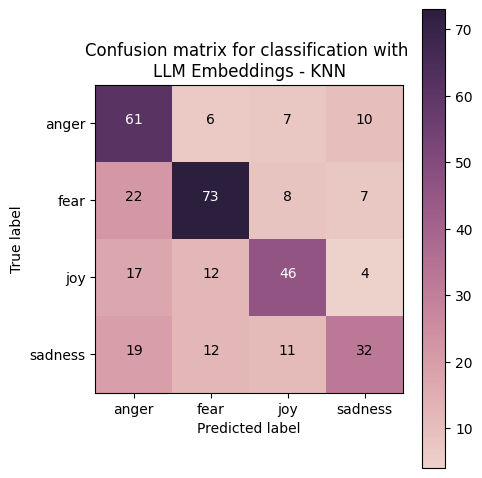

In [182]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(y_true=y_test, y_pred=y_pred) 
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm2, classes=my_tags, title='Confusion matrix for classification with \nLLM Embeddings - KNN')

Now let's also try to apply our **Neural Network** to these embeddings:

In [183]:
X_embgemma_train = np.vstack(df_train["embeddings"].to_numpy()) #Defining our train set

In [184]:
X_embgemma_test = np.vstack(df_test["embeddings"].to_numpy()) #Defining our test set

In [185]:
X_embgemma_train.shape #(Number of data, embeddinggemma embedding size)

(3613, 768)

In [186]:
X_embgemma_test.shape #(Number of data, embeddinggemma embedding size)

(347, 768)

In [187]:
# deal with label (string -> one-hot)
import keras
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 448       anger
1198       fear
3275    sadness
2050        joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


In [188]:
#One-hot encoding our labels
y_train_embgemma = label_encode(label_encoder, y_train)  
y_test_embgemma = label_encode(label_encoder, y_test)

In [189]:
# I/O check
input_shape_embgemma = len(X_embgemma_train[0])
print('input_shape: ', input_shape_embgemma)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  768
output_shape:  4


In [190]:
#We try the same Neural Network Model Again
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape_embgemma, ))  # 3072
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary() #We can notice that our parameter numbers went up because of the increase in the dimension of our input

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,636 (209.52 KB)

 Trainable params: 53,636 (209.52 KB)

 Non-trainable params: 0 (0.00 B)

In [191]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log_2.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_embgemma_train, y_train_embgemma, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_embgemma_test, y_test_embgemma))
print('training finish')

Epoch 1/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4841 - loss: 1.2117 - val_accuracy: 0.6657 - val_loss: 0.9557
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.8383 - val_accuracy: 0.6945 - val_loss: 0.8275
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7296 - loss: 0.7267 - val_accuracy: 0.7061 - val_loss: 0.8113
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7526 - loss: 0.6675 - val_accuracy: 0.7262 - val_loss: 0.7853
Epoch 5/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7711 - loss: 0.6175 - val_accuracy: 0.7349 - val_loss: 0.7902
Epoch 6/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7908 - loss: 0.5766 - val_accuracy: 0.6916 - val_loss: 0.8027
Epoch 7/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8015 - loss: 0.5480 - val_accuracy: 0.6859 - val_loss: 0.8442
Epoch 8/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8112 - loss: 0.5297 - val_accuracy: 0.

In [192]:
## predict
pred_result = model.predict(X_embgemma_test, batch_size=128)
pred_result[:5]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[3.9621531e-03, 7.8770071e-01, 2.0671947e-01, 1.6176816e-03],
       [9.9858665e-01, 4.9129161e-05, 1.2249946e-05, 1.3519364e-03],
       [2.5169409e-06, 9.9994481e-01, 1.5547477e-07, 5.2532516e-05],
       [2.7235677e-05, 9.9805427e-01, 1.7564406e-04, 1.7428655e-03],
       [9.9595731e-01, 3.4130924e-05, 3.6432650e-03, 3.6531113e-04]],
      dtype=float32)

In [193]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['fear', 'anger', 'fear', 'fear', 'anger'], dtype=object)

In [194]:
from sklearn.metrics import accuracy_score
#Accuracy
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test_embgemma), pred_result), 2)))

testing accuracy: 0.65


In [195]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log_2.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.484085,1.211735,0.665706,0.955742
1,1,0.685026,0.838306,0.694524,0.827507
2,2,0.729588,0.726735,0.706052,0.811305
3,3,0.752560,0.667470,0.726225,0.785278
4,4,0.771104,0.617502,0.734870,0.790156
5,5,0.790756,0.576569,0.691643,0.802652
6,6,0.801550,0.548021,0.685879,0.844195
7,7,0.811237,0.529703,0.697406,0.847505
8,8,0.820371,0.493769,0.720461,0.864372
9,9,0.830335,0.473075,0.680115,0.884378


In [196]:
print(classification_report(y_true=label_decode(label_encoder, y_test_embgemma), y_pred=pred_result))

              precision    recall  f1-score   support

       anger       0.59      0.71      0.65        84
        fear       0.72      0.65      0.68       110
         joy       0.62      0.70      0.65        79
     sadness       0.68      0.54      0.60        74

    accuracy                           0.65       347
   macro avg       0.65      0.65      0.65       347
weighted avg       0.66      0.65      0.65       347



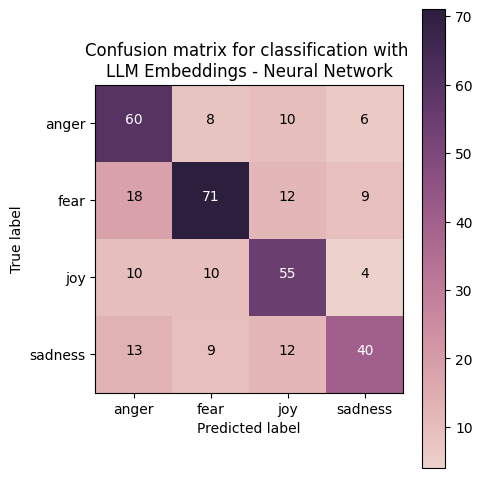

In [197]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm3 = confusion_matrix(y_true=label_decode(label_encoder, y_test_embgemma), y_pred=pred_result) 
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm3, classes=my_tags, title='Confusion matrix for classification with \nLLM Embeddings - Neural Network')

---

### <a id='toc1_3_8_'></a>[**2.8 Few-Shot Prompting Classification:**](#toc0_)
Few-shot prompting classification for LLMs involves giving the model a few labeled examples (typically 5 or fewer) within a prompt to guide it in performing a classification task. Instead of needing extensive training, the LLM uses these examples to understand the task and classify new inputs. This approach is significant in current research because it allows LLMs to perform well on tasks with minimal labeled data, reducing the need for large training datasets and making it highly flexible for various NLP tasks, including those in low-resource languages or niche domains.

In this lab exercise, we will explore zero-shot, 1-shot, and 5-shot prompting for classification using an LLM:

- Zero-shot means the model performs classification without seeing any examples beforehand.
- 1-shot provides the model with just one labeled example per class to guide its classification.
- 5-shot gives the model five labeled examples per class to improve its understanding of the task.

Since processing large datasets can be computationally demanding, we will only sample 20 test texts per emotion for the classification task, allowing us to test the model's performance more efficiently without using the entire test set.

**Process order: Explanation Prompt -> Examples + labels (if it is not zero-shot) -> Text to classify**

**Recommendation for the explanation prompt:** Explain to the model that it is a classification model of certain labels, and to only output the label word, and no other explanation. In this case if the model does not follow the instructions we are retrying the same text until it outputs one of the accepted labels for it.

In [198]:
import pandas as pd
import ollama

# Let's copy our dataframes for training and testing
df_train = train_df
df_test = test_df

In [199]:
import ollama
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import enum
from pydantic import BaseModel

# Define the emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness']
# Define the model to use for few-shot prompting
model_ollama = "gemma3:4b" # gemma3:270m  gemma3:4b  llama3.2:1b

# Schema for the output, the type enum can be used to make a pool of options if what we want is to classify our text selecting only one of them
class Emotion(enum.StrEnum):
    ANGER = 'anger'
    FEAR = 'fear'
    JOY = 'joy'
    SADNESS = 'sadness'

class EmotionLabel(BaseModel):
    label: Emotion

# Function to sample examples per emotion category
def sample_few_shots(df, emotions, num_samples=5):
    few_shot_examples = {}
    for emotion in emotions:
        few_shot_examples[emotion] = df[df['emotion'] == emotion].sample(n=num_samples, random_state=42)
    return few_shot_examples

# Function to build the prompt based on the number of examples (few-shot, 1-shot, zero-shot)
def build_prompt(examples, emotions, num_shots=5):
    classification_instructions = """
You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    """
    
    prompt = classification_instructions + "\n\n"
    
    if num_shots > 0:
        prompt += f"Examples: \n"
        for emotion in emotions:
            for _, row in examples[emotion].iterrows():
                prompt += f"Text: {row['text']}\nEmotion: {emotion}\n\n" #Show the examples in the same format it will be shown for the classification text
                if num_shots == 1:  # If 1-shot, break after the first example for each emotion
                    break
    return prompt

# Function to classify using the LLM with retry for incorrect responses
def classify_with_llm(test_text, prompt_base):
    valid_emotions = ['anger', 'fear', 'joy', 'sadness']
    response = None
    while not response or response not in valid_emotions:
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nEmotion: " #The classification text will leave the emotion label to be filled in by the LLM
        result = ollama.chat(model=model_ollama, format=EmotionLabel.model_json_schema(), messages=[
            {'role': 'user', 'content': full_prompt}
        ])
        emotion_result = EmotionLabel.model_validate_json(result.message.content)

        # response = result['message']['content'].strip().lower()  # Clean and standardize the response
        response = str(emotion_result.model_dump()['label'])
        if response not in valid_emotions:  # Retry if not a valid response
            print(f"Invalid response: {response}. Asking for reclassification.")
    return response

# Main function to run the experiment with the option for zero-shot, 1-shot, or 5-shot prompting
def run_experiment(df_train, df_test, test_samples=5, num_shots=5):
    # Sample examples for few-shot prompting based on num_shots
    if num_shots > 0:
        few_shot_examples = sample_few_shots(df_train, emotions, num_samples=num_shots) 
        prompt_base = build_prompt(few_shot_examples, emotions, num_shots=num_shots)
    else:
        prompt_base = build_prompt(None, emotions, num_shots=0)  # Zero-shot has no examples

    # Prepare to classify the test set
    predictions = []
    true_labels = []
    print(prompt_base)
    # Sample 20 examples per emotion for the test set to classify
    test_samples = sample_few_shots(df_test, emotions, num_samples=test_samples)

    # Classify 20 test examples (5 from each category) and save predictions
    for emotion in emotions:
        for _, test_row in test_samples[emotion].iterrows():
            test_text = test_row['text']
            predicted_emotion = classify_with_llm(test_text, prompt_base)
            predictions.append(predicted_emotion)
            true_labels.append(emotion)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Classification report
    print(classification_report(y_true=true_labels, y_pred=predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=predictions) 
    my_tags = ['anger', 'fear', 'joy', 'sadness']
    plot_confusion_matrix(cm, classes=my_tags, title=f'Confusion matrix for classification with \n{num_shots}-shot prompting')


You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    


Accuracy: 45.00%
              precision    recall  f1-score   support

       anger       0.36      0.60      0.45        20
        fear       0.67      0.20      0.31        20
         joy       0.54      0.70      0.61        20
     sadness       0.40      0.30      0.34        20

    accuracy                           0.45        80
   macro avg       0.49      0.45      0.43        80
weighted avg       0.49      0.45      0.43        80



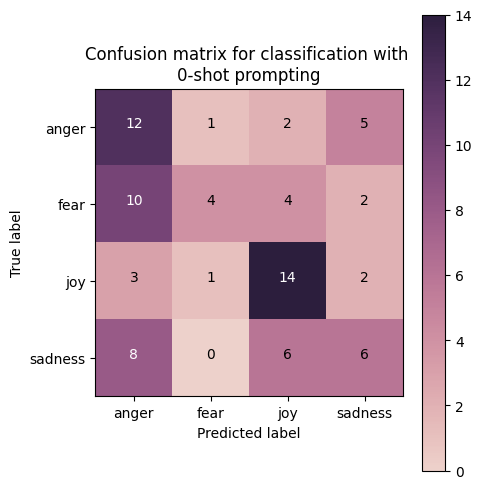

In [200]:
# Example of running the experiment with zero-shot prompting
run_experiment(df_train, df_test, test_samples=20, num_shots=0)


You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    

Examples: 
Text: @winksahoy we about to get shit on by the wrath of winter out of nowhere
Emotion: anger

Text: @LakersTakeover it ain't that serious. #HOUvsNE  #igotbetterthingstodotonightthandie
Emotion: fear

Text: #Talking about our #Problems is our greatest #Addiction#Break the #habitTalk about ur #Joys#quote #optimism #problemsolving #behappy
Emotion: joy

Text: #PeopleLikeMeBecause of some unknown reason but I try to discourage it
Emotion: sadness


Accuracy: 45.00%
              precision    recall  f1-score   support

       anger       0.43      0.65      0.52        20
        fear       0.50      0.30      0.38        20
      

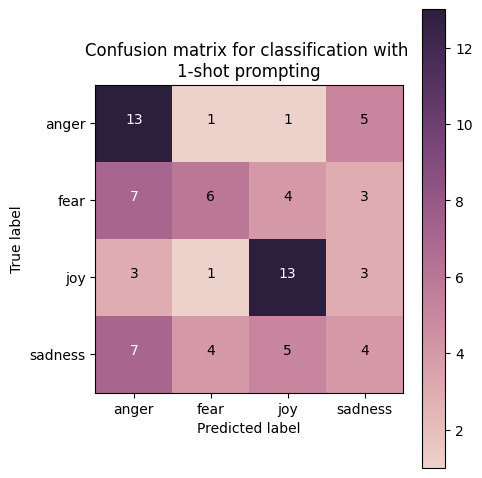

In [201]:
# Example of running the experiment with 1-shot prompting
run_experiment(df_train, df_test, test_samples=20, num_shots=1)


You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    

Examples: 
Text: @winksahoy we about to get shit on by the wrath of winter out of nowhere
Emotion: anger

Text: I really really resent having to go to bed at a sensible hour, you guys. I WANT TO TALK TO MY PEOPLE.
Emotion: anger

Text: Inner conflict happens when we are at odds with ourselves. Honor your values and priorities.  #innerconflict #conflict #values
Emotion: anger

Text: I'm girly in the sense that I always have lashes &amp; nails done but tomboy in the sense that black is my only color &amp; refuse the ruffle life
Emotion: anger

Text: @soyoprincess they irritate me. Them and their inch thick made up masks
Emotion: anger

Text:

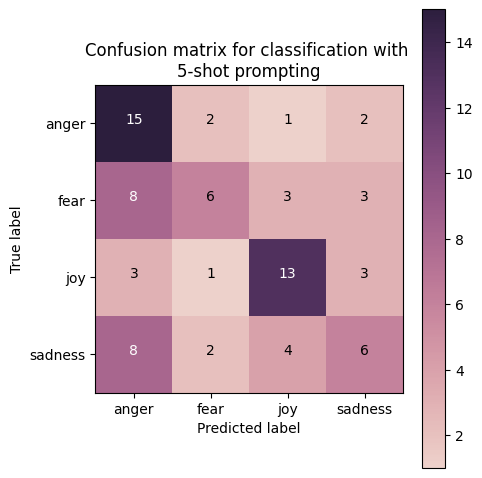

In [202]:
# Example of running the experiment with 5-shot prompting
run_experiment(df_train, df_test, test_samples=20, num_shots=5)

---